In [42]:
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import PIL
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, LeakyReLU, Dense, Dropout
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from keras.losses import categorical_crossentropy
import pandas as pd 
from keras.regularizers import l2
from keras import models
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import model_from_json

import numpy as np
from sklearn import linear_model

**Importing the libraries **

In [43]:
train_set_path = "/content/drive/MyDrive/Face image classification/train1"
test_set_path = "/content/drive/MyDrive/Face image classification/test"

**The train path and the test path are defined. **

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The drive is mounted

In [45]:
x = plt.imread("/content/drive/MyDrive/Face image classification/test/happy/PublicTest_6949642.jpg")
x.shape

(48, 48)

In [46]:

image_size = (48, 48) # (width, height)

class_map = {
    'surprise': 0,
    'fear': 1,
    'angry': 2,
    'neutral': 3,
    'sad': 4,
    'disgust': 5,
    'happy': 6
}

random_state = 40

**Image size, and the 7 classes of emotions are defined **

In [49]:
!ls "/content/drive/MyDrive/Face image classification" 

test  train  train1


Train1 is the reduced dataset, test is the training dataset
Train is the dataset with full size. This model is with the reduced dataset(Train1)

In [50]:
def create_dataset(file_path):
    df = pd.DataFrame()
    
    for cat in os.listdir(file_path):
        image_file = os.listdir(os.path.join(file_path, cat))
        label = [cat] * len(image_file)
        tmp_df = pd.DataFrame([image_file, label]).T
        tmp_df.columns = ['image_file', 'label']
        df = pd.concat([df, tmp_df])
        
    return df

def display_sample_image(img_num=10):
    plt.figure(figsize=(10,5))
    for i, v in train_df.sample(10).reset_index().iterrows():
        label = v.label
        image_file = v.image_file
        path = os.path.join(os.path.join(train_set_path, label), image_file)
        image = cv2.imread(image_file)
        plt.subplot(2,5,i+1)
        plt.grid(False)
        plt.xlabel(label)

        plt.imshow(image)

        
def preprocess_image(image):
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, image_size, interpolation = cv2.INTER_AREA) # resize (48, 48)
    image = np.array(image) # convert pixel to float
    image = image.astype('float32')
    image /= 255 # normalize
    
    return image

def prepare_dataset(df, class_map):
    image_array = []
    class_name = []
    
    for i, row in df.iterrows():
        
        image_path = row.image_file
        image_class = class_map[row.label]
        
        image = cv2.imread(image_path, 0) # load image (0 = grayscale)
        image = preprocess_image(image) # preprocess (resize -> convert pixel to float -> normalize)
        
        image_array.append(image)
        class_name.append(image_class)
        
    return np.array(image_array).reshape((len(image_array), image_size[0], image_size[1], 1)), to_categorical(np.array(class_name))

**Creating the dataset, displaying the sample image, prepocessing the image amd preparing the dataset funcitons are defined.**

In [51]:
img_height = image_size[1]
img_width = image_size[0]
input_shape = (img_height, img_width, 1)

num_classes = len(class_map)

Model 1: A CNN model is defined for this model. With a convolution layer of 32 and 64 feature maps, 3 * 3 kernel size, activation function RELU. Max pooling with 2*2 kernel size. And a dense layer with RELU and SOFTMAX activation functions. 


To reduce the overfitting of the Model1 Dropout regularization and L2 regularization are done.

Model 2
Dropout regularization ignores a random subset of units in a layer while setting their weights to zero during that phase of training.The ideal rate for the input and hidden layers is 0.4, and the ideal rate for the output layer is 0.2. 

Model 3:
Regularization optimizes a model by penalizing complex models, therefore minimizing loss and complexity.Thus this forces our neural network to be simpler. Here we will use an L2 regularizer,Here we’ll add a regularizer to the second and third layers of our network with a learning rate (lr) of 0.0001. 

In [59]:
def create_model(input_shape, num_classes):
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPool2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPool2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    print(model.summary())
    
    return model

def create_model2(input_shape, num_classes):
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPool2D((2, 2)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPool2D((2, 2)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    print(model.summary())
    
    return model
  
def create_model3(input_shape, num_classes):
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(l=0.0001)))
    model.add(layers.MaxPool2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu',  kernel_regularizer=regularizers.l2(l=0.0001)))
    model.add(layers.MaxPool2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu',  kernel_regularizer=regularizers.l2(l=0.0001)))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))

    print(model.summary())
    
    return model

In [60]:
batch_size = 64

Batch size of 64 is set

In [61]:
def train_model(model, train_set, val_set, optimizer, loss, metrics, epochs, batch_size, class_weight, callbacks):
    
    model.compile(optimizer=Adam(lr=1e-3, decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])
    
    history = model.fit(train_set[0], train_set[1],
                    validation_data=(val_set[0], val_set[1]), 
                    epochs=epochs,
                    batch_size=batch_size,
                    class_weight=class_weight,
                    callbacks=callbacks)
    
    return model, history

def plot_trian_history(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

training funciton for displaying the accuracy and the validation loss

In [62]:
def plot_image_and_emotion(image, label, prediction):
    fig, axs = plt.subplots(1, 2, figsize=(20, 6), sharey=False)
    
    bar_label = class_map.keys()
    
    image = np.reshape(image, (image.shape[0], image.shape[1]))
    
    axs[0].imshow(image, "gray")
    axs[0].set_title(label)
    
    axs[1].bar(bar_label, prediction)
    axs[1].grid()
    
    plt.show()

Function for plotting the image and plotting 

In [64]:
model_list = {
    'model_1': {
        'model': create_model,
        'trained_model': None,
        'history': None,
        'test_acc': None,
        'test_loss': None,
        'prediction': None
    },
    'model_2': {
        'model': create_model2,
        'trained_model': None,
        'history': None,
        'test_acc': None,
        'test_loss': None,
        'prediction': None
    },
    'model_3': {
        'model': create_model3,
        'trained_model': None,
        'history': None,
        'test_acc': None,
        'test_loss': None,
        'prediction': None
    }
}

acc_list = {
    'model_1': 0,
    'model_2': 0,
    'model_3': 0,
    'model_4': 0
}

=============== CREATE DATASET ===============

train set:  (14643, 2)
test set:  (7178, 2)

=============== Prepare Dataset ===============

Train: (11714, 11714)
Validate: (2929, 2929)
Test: (7178, 7178)

=============== Train Model ===============

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


184/184 [==============================] - 34s 180ms/step - loss: 0.2785 - accuracy: 0.2642 - val_loss: 1.7656 - val_accuracy: 0.3284
Epoch 2/50
184/184 [==============================] - 33s 180ms/step - loss: 0.2477 - accuracy: 0.3550 - val_loss: 1.6133 - val_accuracy: 0.3793
Epoch 3/50
184/184 [==============================] - 33s 180ms/step - loss: 0.2352 - accuracy: 0.3914 - val_loss: 1.5289 - val_accuracy: 0.4210
Epoch 4/50
184/184 [==============================] - 33s 181ms/step - loss: 0.2239 - accuracy: 0.4239 - val_loss: 1.5045 - val_accuracy: 0.4295
Epoch 5/50
184/184 [==============================] - 33s 180ms/step - loss: 0.2130 - accuracy: 0.4521 - val_loss: 1.4355 - val_accuracy: 0.4595
Epoch 6/50
184/184 [==============================] - 33s 179ms/step - loss: 0.2013 - accuracy: 0.4822 - val_loss: 1.4797 - val_accuracy: 0.4623
Epoch 7/50
184/184 [==============================] - 33s 180ms/step - loss: 0.1955 - accuracy: 0.5044 - val_loss: 1.4318 - val_accuracy: 0.4

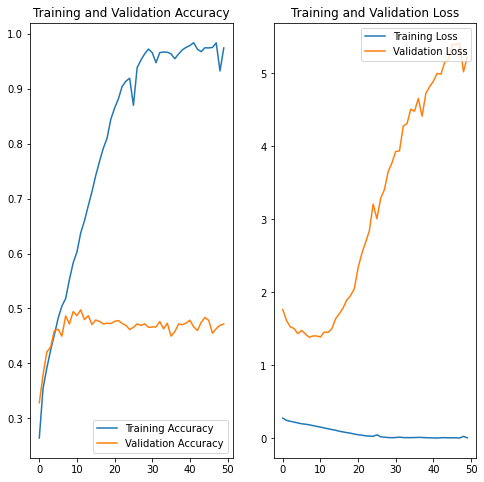

225/225 [==============================] - 5s 24ms/step - loss: 5.4761 - accuracy: 0.4698
[model_1] test accuracy:0.4697687327861786
367/367 [==============================] - 9s 24ms/step - loss: 0.0337 - accuracy: 0.9911
[model_1] train accuracy:0.9911217093467712
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 23, 23, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 21, 21, 64)        18496     
                                                   

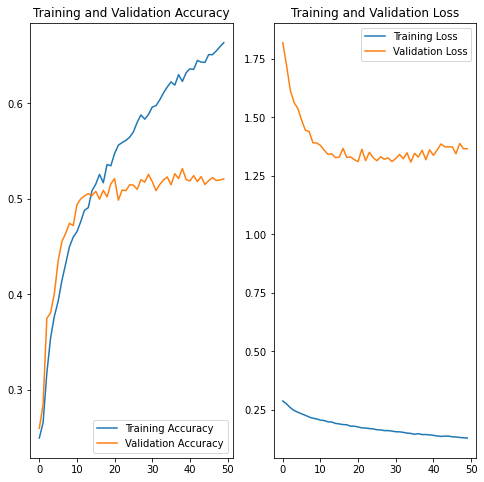

225/225 [==============================] - 5s 23ms/step - loss: 1.3476 - accuracy: 0.5238
[model_2] test accuracy:0.5238227844238281
367/367 [==============================] - 8s 23ms/step - loss: 0.5827 - accuracy: 0.8303
[model_2] train accuracy:0.8302885293960571
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                               

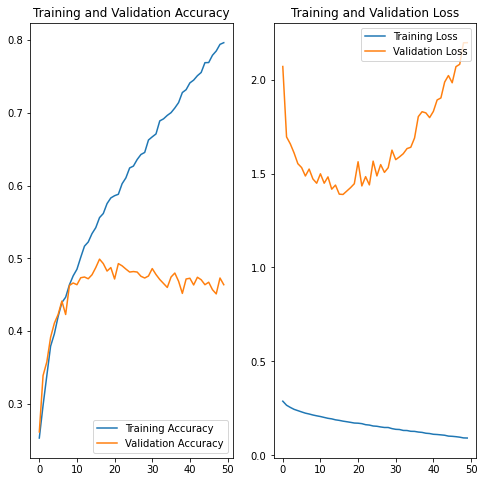

225/225 [==============================] - 5s 24ms/step - loss: 2.1832 - accuracy: 0.4763
[model_3] test accuracy:0.47631651163101196
367/367 [==============================] - 9s 24ms/step - loss: 0.6120 - accuracy: 0.8012
[model_3] train accuracy:0.8011780977249146

=============== Save Trained Model ===============



In [65]:
# 1. Create Dataset
print("=============== CREATE DATASET ===============")
print()
train_df = create_dataset(train_set_path)
train_df["image_file"] = train_df.apply(lambda x : os.path.join(os.path.join(train_set_path, x['label']), x['image_file']), axis=1)

test_df = create_dataset(test_set_path)
test_df["image_file"] = test_df.apply(lambda x : os.path.join(os.path.join(test_set_path, x['label']), x['image_file']), axis=1)

print("train set: ", train_df.shape)
print("test set: ", test_df.shape)

# display_sample_image(img_num=10)

# 2. Prepare Dataset
print()
print("=============== Prepare Dataset ===============")
print()
train_ds, val_ds = train_test_split(train_df, test_size=0.2, random_state=random_state)

X_train, y_train = prepare_dataset(train_ds, class_map)
X_val, y_val = prepare_dataset(val_ds, class_map)
X_test, y_test = prepare_dataset(test_df, class_map)

print("Train: ({}, {})".format(str(len(X_train)), str(len(y_train))))
print("Validate: ({}, {})".format(str(len(X_val)), str(len(y_val))))
print("Test: ({}, {})".format(str(len(X_test)), str(len(y_test))))

# 3. Train Model
print()
print("=============== Train Model ===============")
print()
class_weight = (train_df.label.value_counts() / train_df.shape[0])
class_weight.index = class_weight.index.map(class_map)
class_weight = class_weight.to_dict()

epochs = 50

for m in model_list:
    earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', min_delta=0.1, patience=5)
    model = model_list[m]['model']
    trained_model, history = train_model(model=model(input_shape, num_classes),
                                         train_set=(X_train, y_train),
                                         val_set=(X_val, y_val),
                                         optimizer=Adam(lr=1e-3, decay=1e-6),
                                         loss=categorical_crossentropy,
                                         metrics=['accuracy'],
                                         epochs=epochs,
                                         batch_size=64,
                                         class_weight=class_weight,
                                         callbacks=None)
    
    # keep trained_model, history, prediction
    model_list[m]['trained_model'] = trained_model
    model_list[m]['history'] = history
    model_list[m]['prediction'] = trained_model.predict(X_test)
    
    # plot history
    # plot_trian_history(history, earlystop_callback.stopped_epoch + 1)
    plot_trian_history(history, epochs)
    
    # evaluate
    test_loss, test_acc = trained_model.evaluate(X_test, y_test)
    print('[{}] test accuracy:{}'.format(m, test_acc))
    # keep loss, accuracy
    model_list[m]['test_acc'] = test_acc
    model_list[m]['test_loss'] = test_loss
    acc_list[m] = test_acc
    # evaluate
    train_loss, train_acc = trained_model.evaluate(X_train, y_train)
    print('[{}] train accuracy:{}'.format(m, train_acc))
    # keep loss, accuracy
    model_list[m]['train_acc'] = train_acc
    model_list[m]['train_acc'] = train_acc
    acc_list[m] = train_acc
    
# 4. Save The Best Trained Model
print()
print("=============== Save Trained Model ===============")
print()
# serialize model to JSON
best_model = max(acc_list, key=acc_list.get)
trained_model = model_list[best_model]['trained_model']
model_json = trained_model.to_json()

with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
trained_model.save_weights("model.h5")

In [69]:
for m in model_list:
    print("MODEL : {} - TRAIN_ACCURACY : {}".format(m, model_list[m]['train_acc']))
    print("MODEL : {} - TEST_ACCURACY : {}".format(m, model_list[m]['test_acc']))

MODEL : model_1 - TRAIN_ACCURACY : 0.9911217093467712
MODEL : model_1 - TEST_ACCURACY : 0.4697687327861786
MODEL : model_2 - TRAIN_ACCURACY : 0.8302885293960571
MODEL : model_2 - TEST_ACCURACY : 0.5238227844238281
MODEL : model_3 - TRAIN_ACCURACY : 0.8011780977249146
MODEL : model_3 - TEST_ACCURACY : 0.47631651163101196


Model 1 is CNN, Model 2 is with dropout regularization, Model 3 is with L2 regularization.

In [68]:
sns.set(font_scale=1.5)
sns.set_style("dark")

In [70]:
def get_test_image(test_image_array, test_image_label, pred_test_labels, image_number):
    image = test_image_array[image_number]
    label = list(class_map.keys())[list(class_map.values()).index(list(test_image_label[image_number]).index(1))]
    prediction = pred_test_labels[image_number]
    
    return image, label, prediction

In [71]:
pred_test_labels = model_list[best_model]['prediction']
test_df.reset_index().sample(10)

index                                         image_file     label
6875    944  /content/drive/MyDrive/Face image classificati...       sad
772     772  /content/drive/MyDrive/Face image classificati...     happy
244     244  /content/drive/MyDrive/Face image classificati...     happy
3776    978  /content/drive/MyDrive/Face image classificati...   neutral
163     163  /content/drive/MyDrive/Face image classificati...     happy
3983   1185  /content/drive/MyDrive/Face image classificati...   neutral
2957    159  /content/drive/MyDrive/Face image classificati...   neutral
6889    958  /content/drive/MyDrive/Face image classificati...       sad
4872    730  /content/drive/MyDrive/Face image classificati...  surprise
1075   1075  /content/drive/MyDrive/Face image classificati...     happy

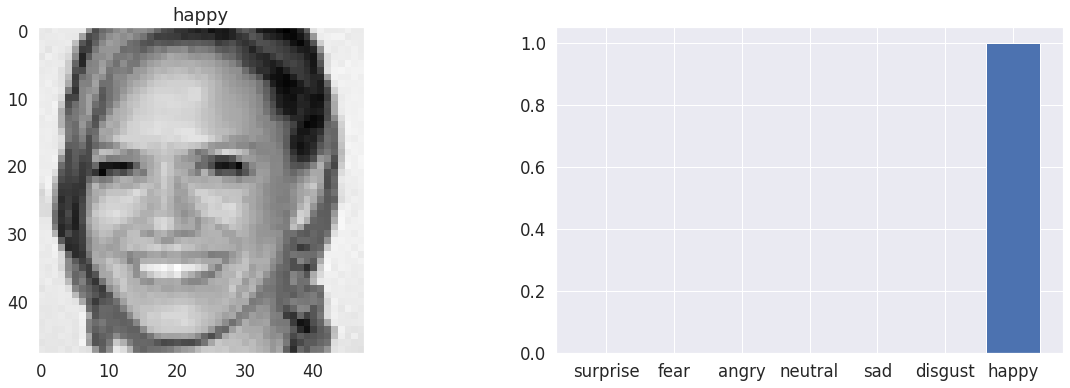

In [72]:
image, label, prediction =  get_test_image(X_test, y_test, pred_test_labels, image_number=25)
plot_image_and_emotion(image, label, prediction)

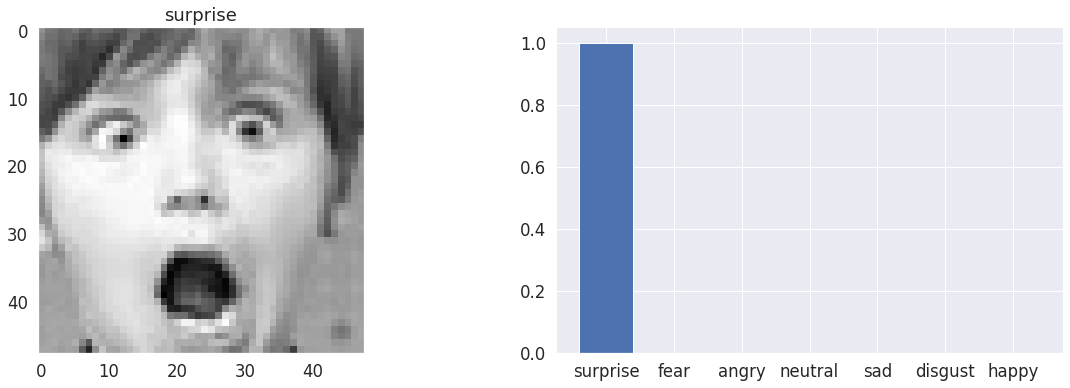

In [73]:
image, label, prediction =  get_test_image(X_test, y_test, pred_test_labels, image_number=4444)
plot_image_and_emotion(image, label, prediction)

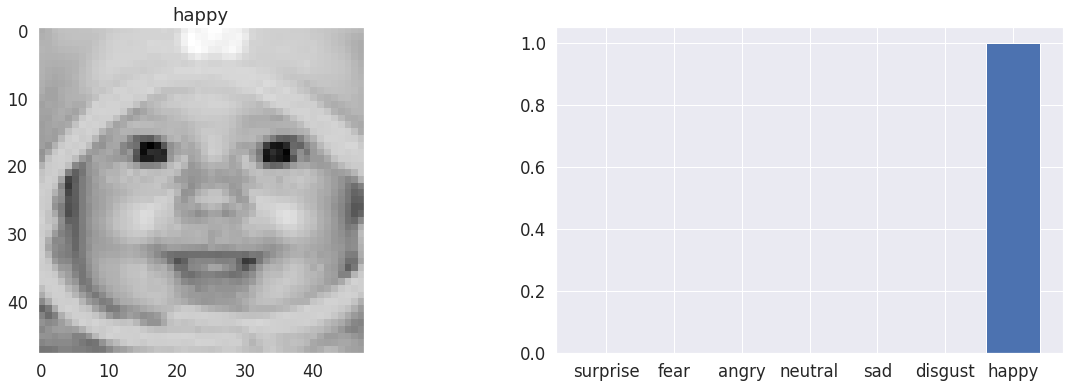

In [74]:
image, label, prediction =  get_test_image(X_test, y_test, pred_test_labels, image_number=77)
plot_image_and_emotion(image, label, prediction)

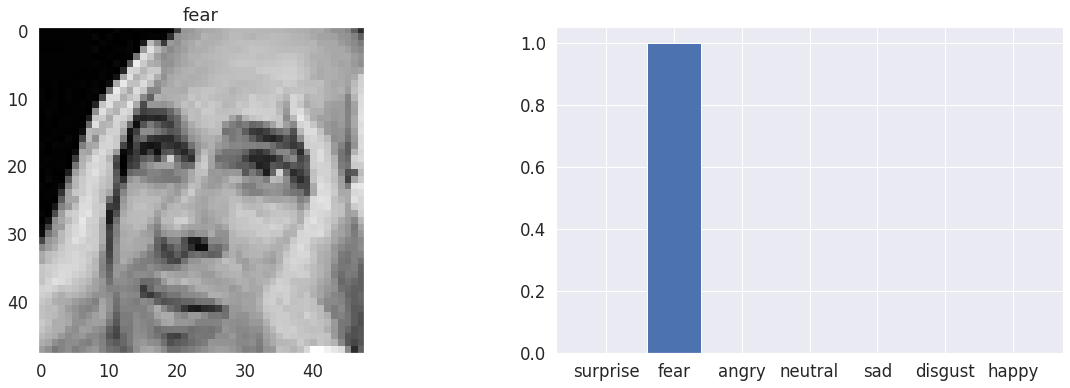

In [75]:
image, label, prediction =  get_test_image(X_test, y_test, pred_test_labels, image_number=2478)
plot_image_and_emotion(image, label, prediction)

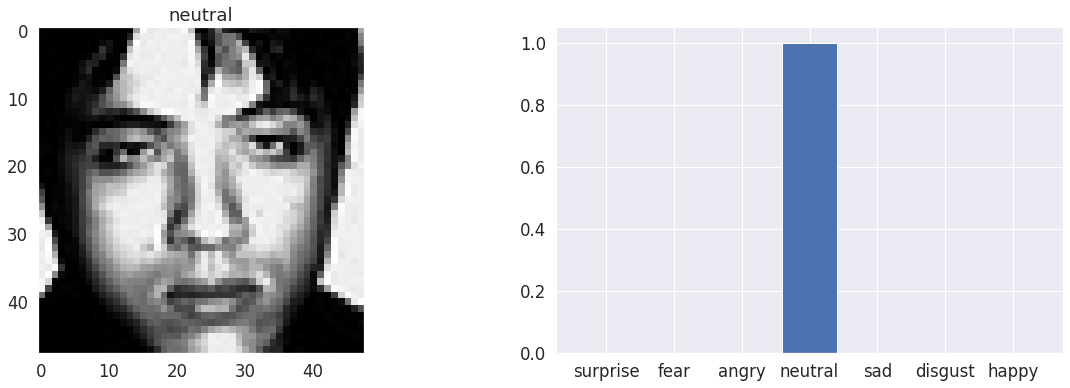

In [76]:
image, label, prediction =  get_test_image(X_test, y_test, pred_test_labels, image_number=3469)
plot_image_and_emotion(image, label, prediction)

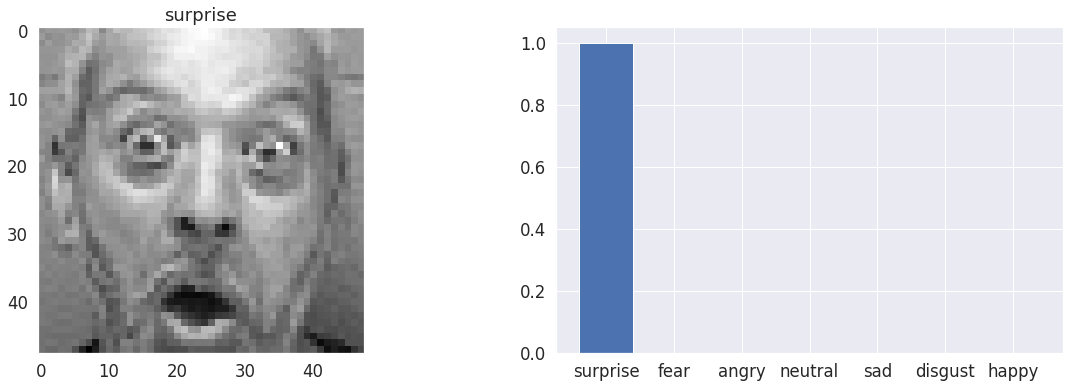

In [91]:
image, label, prediction =  get_test_image(X_test, y_test, pred_test_labels, image_number=4566)
plot_image_and_emotion(image, label, prediction)

In [89]:
image, label, prediction =  get_test_image(X_test, y_test, pred_test_labels, image_number=5688)
plot_image_and_emotion(image, label, prediction)

In [81]:
image, label, prediction =  get_test_image(X_test, y_test, pred_test_labels, image_number=6766)
plot_image_and_emotion(image, label, prediction)

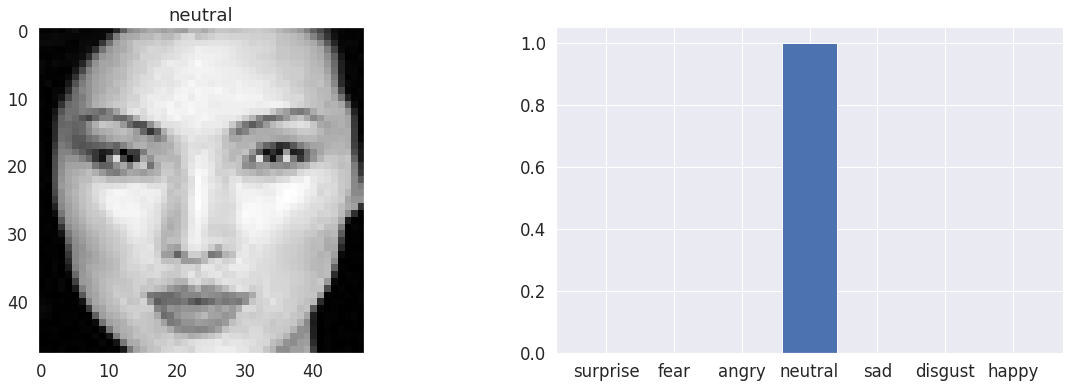

In [85]:
image, label, prediction =  get_test_image(X_test, y_test, pred_test_labels, image_number=3588)
plot_image_and_emotion(image, label, prediction)

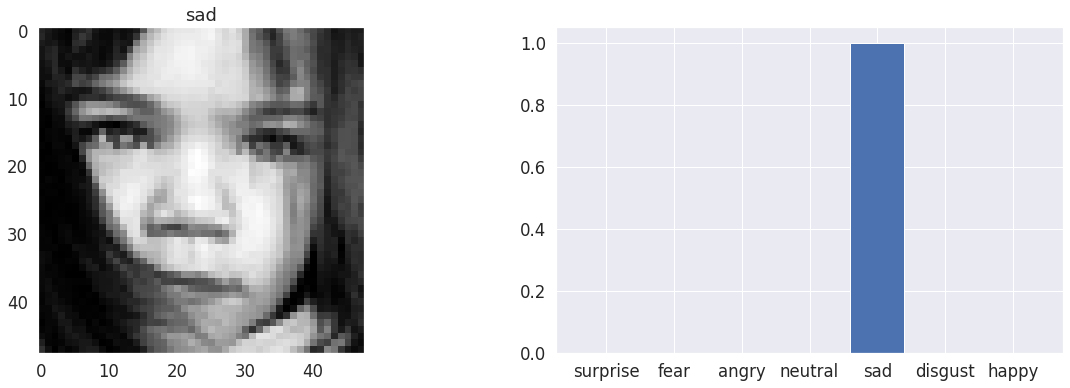

In [86]:
image, label, prediction =  get_test_image(X_test, y_test, pred_test_labels, image_number=6900)
plot_image_and_emotion(image, label, prediction)

In [87]:
key_list = list(class_map.keys())
val_list = list(class_map.values())
c_matrix = confusion_matrix(y_true=np.argmax(y_test, axis=1).tolist(), 
                            y_pred=np.argmax(pred_test_labels, axis=1).tolist())

plt.subplots(figsize=(15, 10))
sns.heatmap(c_matrix, annot=True,  fmt='d', xticklabels=key_list, yticklabels=key_list)

In [88]:
print(classification_report(y_true=np.argmax(y_test, axis=1).tolist(), 
                            y_pred=np.argmax(pred_test_labels, axis=1).tolist(),
                            target_names=list(class_map.keys())))

              precision    recall  f1-score   support

    surprise       0.65      0.59      0.62       831
        fear       0.31      0.33      0.32      1024
       angry       0.38      0.34      0.36       958
     neutral       0.41      0.42      0.42      1233
         sad       0.33      0.35      0.34      1247
     disgust       0.33      0.39      0.35       111
       happy       0.68      0.69      0.69      1774

    accuracy                           0.47      7178
   macro avg       0.44      0.44      0.44      7178
weighted avg       0.47      0.47      0.47      7178



Classification report

